In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
bcf_mordred = pd.read_csv('data/bcf_mordred.csv', index_col=0)
bcf_ecfp4 = pd.read_csv('data/bcf_ecfp4_1024.csv', index_col=0)

In [7]:
# Why does the model perform so poorly on the pfas dataset?
# Look at chemical space around PFAS data using PCA to see if our training data are far from the target domain

# descriptors kwarg inputs list of mordred descriptors to filter for before doing PCA
def pre_PCA(data, descriptors=None):
    
    def count_cf_bonds(mol):
        abstract_cf = Chem.MolFromSmarts('C~F')
        cf_bonds = mol.GetSubstructMatches(abstract_cf)
        return len(cf_bonds)
    
    bcf_pca = data
    
    # Regenerate rd_mol object and calculate cf bonds
    bcf_pca['rd_mol'] = bcf_pca.cSMILES.apply(Chem.MolFromSmiles)
    bcf_pca['cf_bonds'] = bcf_pca.rd_mol.apply(count_cf_bonds)
    head_columns = ['CAS', 'logBCF', 'Dataset', 'cSMILES', 'rd_mol', 'is_pfas', 'cf_bonds']
    
    # Select for certain Mordred descriptors
    if descriptors is not None:
        bcf_pca = bcf_pca[head_columns + descriptors]
    
    # Create labels: non-PFAS, PFAS-like, PFAS 
    bcf_pca['Category'] = 0 # non-PFAS
    bcf_pca.loc[bcf_pca['cf_bonds'] >= 2, 'Category'] = 1 # pfas-like
    bcf_pca.loc[bcf_pca['is_pfas'] == True, 'Category'] = 2 # pfas
    
    # Convert to numpy arrays
    pre = bcf_pca.drop(columns=head_columns, axis=1)
    y = pre.pop('Category').to_numpy()
    X = pre.to_numpy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

phenol_features = ['nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'apol', 'bpol', 
                   'nRing', 'nHRing', 'naRing', 'naHRing', 'nFRing', 'TopoPSA', 
                   'WPol', 'nHBAcc', 'nHBDon']
X_pre_pca, y_pca = pre_PCA(bcf_mordred)
X_pre_pca_phenol, y_pca_phenol = pre_PCA(bcf_mordred, descriptors=phenol_features)
label_names = ["non-PFAS", "like-PFAS", "PFAS"]

# carboxylic smiles can be added as descriptor, like cf bond --> calculate yourself
# nbase, nacid, number of OH groups, aromaticity
# search for carboxylic acids
# try on these 5:
# mordred polarity - polar surface area
# electronegativity
# polarizability - APol, BPol
# ring count - hetero, aromatic, fused rings
# hydrogen bonding - nHBAcc, nHBDon

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Explained Variance Ratio:
[0.29837426 0.09682531]


Text(0, 0.5, 'PC2')

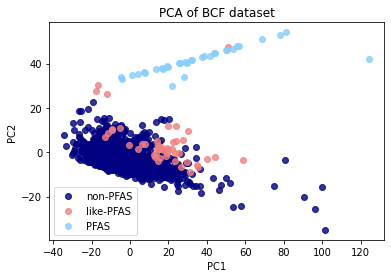

In [8]:
# Plot 2D PCA using all Mordred features
%matplotlib inline
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pre_pca)
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

colors = ["navy", "lightcoral", "lightskyblue"]
for color, i, label_name in zip(colors, [0, 1, 2], label_names):
    plt.scatter(
        X_pca[y_pca == i, 0], X_pca[y_pca == i, 1], color=color, alpha=0.8, label=label_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of BCF dataset")
plt.xlabel('PC1')
plt.ylabel('PC2')

<IPython.core.display.Javascript object>


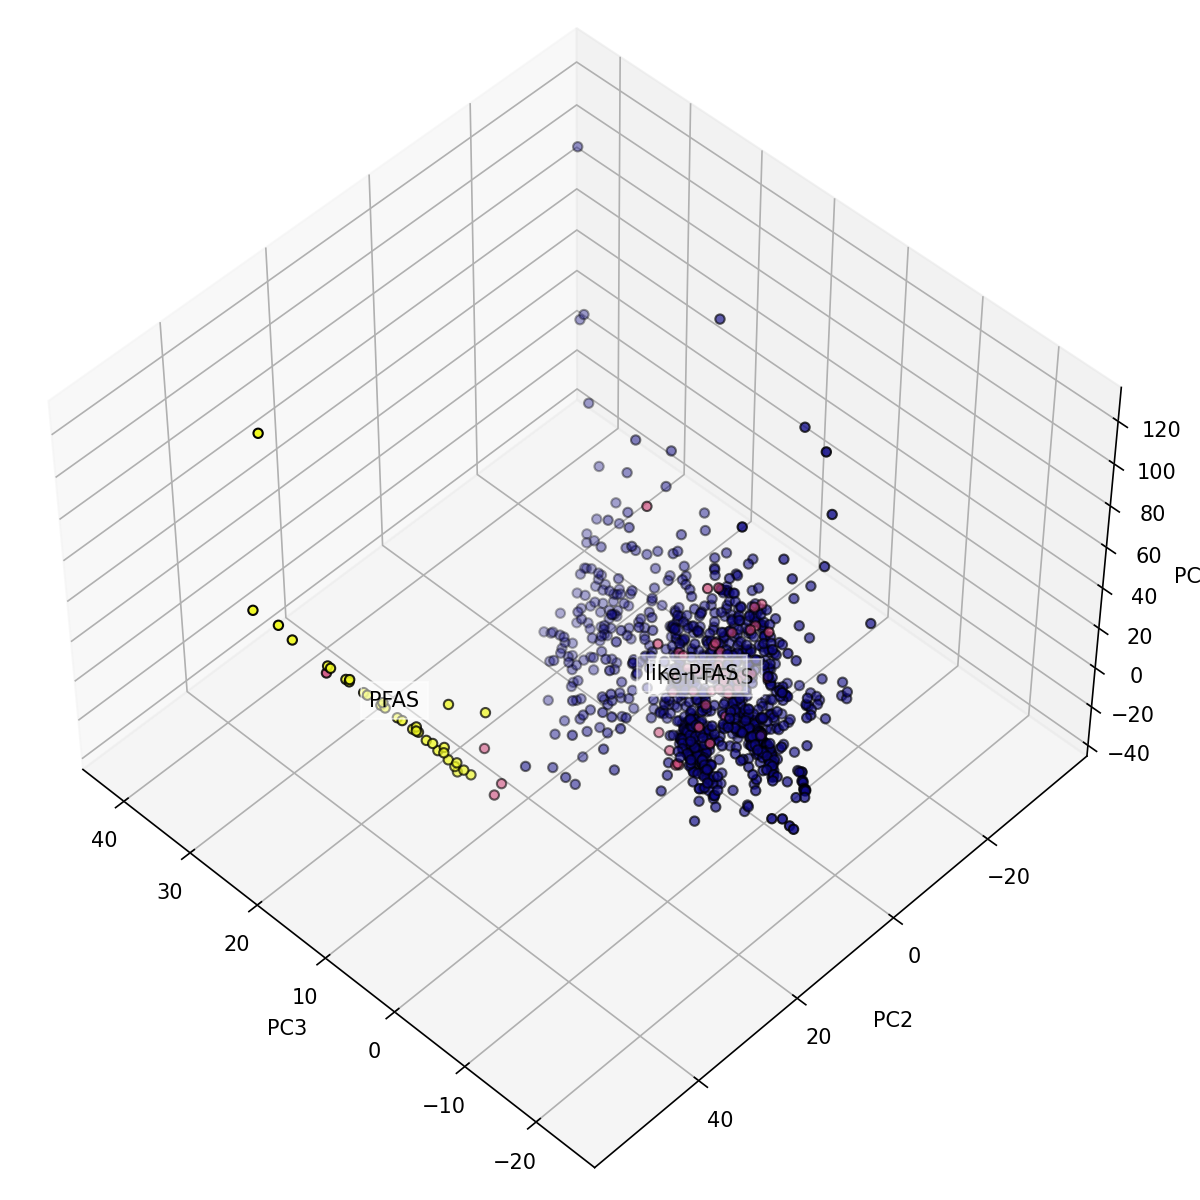

Explained Variance Ratio:
[0.29837426 0.09682531 0.07696134]


Text(0.5, 0, 'PC1')

In [9]:
# PCA 3D for all features
# switch to interactive mode
%matplotlib notebook

fig = plt.figure(1, figsize=(8, 8), dpi=100) #, figsize=(18.5, 10.5)
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])

pca = PCA(n_components=3)
X_pca3d = pca.fit_transform(X_pre_pca)
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# place labels for the clusters
for name, label in [("non-PFAS", 0), ("like-PFAS", 1), ("PFAS", 2)]:
    ax.text3D(
        X_pca3d[y_pca == label, 2].mean(),
        X_pca3d[y_pca == label, 1].mean(),
        X_pca3d[y_pca == label, 0].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
ax.scatter(X_pca3d[:, 2], X_pca3d[:, 1], X_pca3d[:, 0], c=y_pca, cmap=plt.get_cmap('plasma'), edgecolor="k")

ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1')

# Need to add a legend to the scatterplot
# nonpfas = mpatches.Patch(color='red', label='non-pfas')
# likepfas = mpatches.Patch(color='red', label='like-pfas')
# ispfas = mpatches.Patch(color='red', label='pfas')
# ax.legend(handles=[nonpfas, likepfas, ispfas])


# make plot for reference/justification:
# y axis, cumulative explained variance
# x axis, principal component (1,2,3,4,...)
# look for inflection point for convergence point

Explained Variance Ratio:
[0.33767145 0.19598822]


Text(0, 0.5, 'PC2')

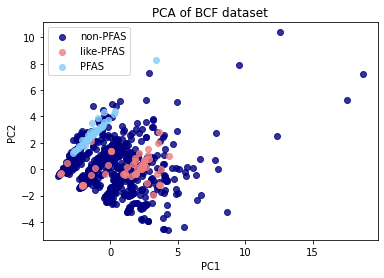

In [10]:
# Plot 2D PCA using phenolic characteristics
%matplotlib inline
pca = PCA(n_components=2)
X_pca_phenol = pca.fit_transform(X_pre_pca_phenol)
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

colors = ["navy", "lightcoral", "lightskyblue"]
for color, i, label_name in zip(colors, [0, 1, 2], label_names):
    plt.scatter(
        X_pca_phenol[y_pca_phenol == i, 0], X_pca_phenol[y_pca_phenol == i, 1], color=color, alpha=0.8, label=label_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of BCF dataset")
plt.xlabel('PC1')
plt.ylabel('PC2')

<IPython.core.display.Javascript object>


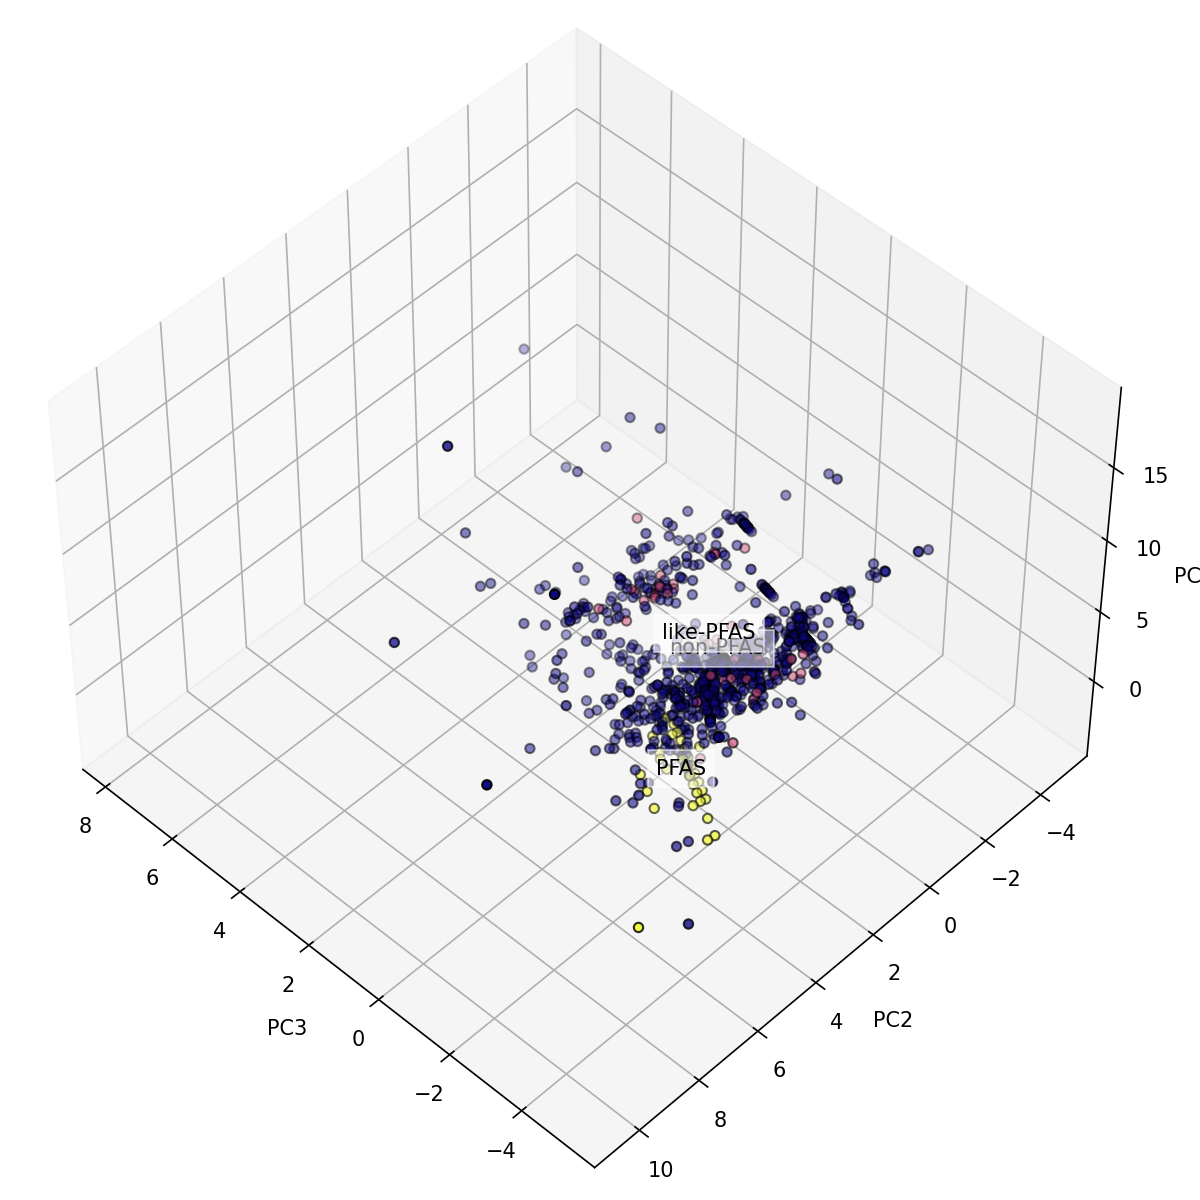

[0.33767145 0.19598822 0.10487036]


Text(0.5, 0, 'PC1')

In [11]:
# PCA 3D for all features
# switch to interactive mode
%matplotlib notebook 

fig = plt.figure(1, figsize=(8, 8), dpi=100) #, figsize=(18.5, 10.5)
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])

pca = PCA(n_components=3)
X_pca3d_phenol = pca.fit_transform(X_pre_pca_phenol)
print(pca.explained_variance_ratio_)

# place labels for the clusters
for name, label in [("non-PFAS", 0), ("like-PFAS", 1), ("PFAS", 2)]:
    ax.text3D(
        X_pca3d_phenol[y_pca_phenol == label, 2].mean(),
        X_pca3d_phenol[y_pca_phenol == label, 1].mean(),
        X_pca3d_phenol[y_pca_phenol == label, 0].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
ax.scatter(X_pca3d_phenol[:, 2], X_pca3d_phenol[:, 1], X_pca3d_phenol[:, 0], c=y_pca_phenol, cmap=plt.get_cmap('plasma'), edgecolor="k")

ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1')

In [12]:
# Calculate euclidean distance from center of PFAS cluster (centroid) in PCA space
def centroid(datapoints):
    # calculate mean of all PC values
    # [:, i] indexes the ith column of a 2D np array
    return np.array([np.mean(datapoints[:, i]) for i in range(datapoints.shape[1])])

# p1, p2 are array of n values along n axes
def euclidean_distance(p1, p2):
    # make sure dimensions are the same
    if p1.shape != p2.shape:
        print("Incompatible dimensions")
        return None
    
    # square root of squares of the absolute distances for each dimension
    return math.sqrt(sum((abs(p1[i] - p2[i]) ** 2 for i in range(len(p1)))))

# Consider distance to closest point in the cluster instead of distance to centroid

In [14]:
# calculate centroid
pfas_mcentroid = centroid(X_pca3d[y_pca == 2])
pfas_pcentroid = centroid(X_pca3d_phenol[y_pca_phenol == 2])

# radius of pfas cluster - furthest away distance of pfas datapoint from centroid
pfas_mradius = max([euclidean_distance(i, pfas_mcentroid) for i in X_pca3d[y_pca == 2]])
pfas_pradius = max([euclidean_distance(i, pfas_pcentroid) for i in X_pca3d_phenol[y_pca_phenol == 2]])
print('Mordred Cluster Radius: ', pfas_mradius) # Mordred cluster is oblong thus larger than expected radius
print('Phenolic Cluster Radius: ', pfas_pradius) 

# filter for points near pfas cluster
mdistance = np.array([euclidean_distance(i, pfas_mcentroid) for i in X_pca3d[y_pca != 2]])
pdistance = np.array([euclidean_distance(i, pfas_pcentroid) for i in X_pca3d_phenol[y_pca_phenol != 2]])

# mordred feature space distance within 55: 219
print('PFAS Mordred-Proximal Points: ', X_pca3d[y_pca != 2][mdistance < 55].shape[0])
X_pca3d_like = X_pca3d[y_pca != 2][mdistance < 55]

# phenolic feature space distance within 3: 198
print('PFAS Phenol-Proximal Points: ', X_pca3d_phenol[y_pca_phenol != 2][pdistance < 3].shape[0])
X_pca3d_phenol_like = X_pca3d_phenol[y_pca_phenol != 2][pdistance < 3]

Mordred Cluster Radius:  91.11854838419066
Phenolic Cluster Radius:  7.793603022284833
PFAS Mordred-Proximal Points:  219
PFAS Phenol-Proximal Points:  198


<IPython.core.display.Javascript object>


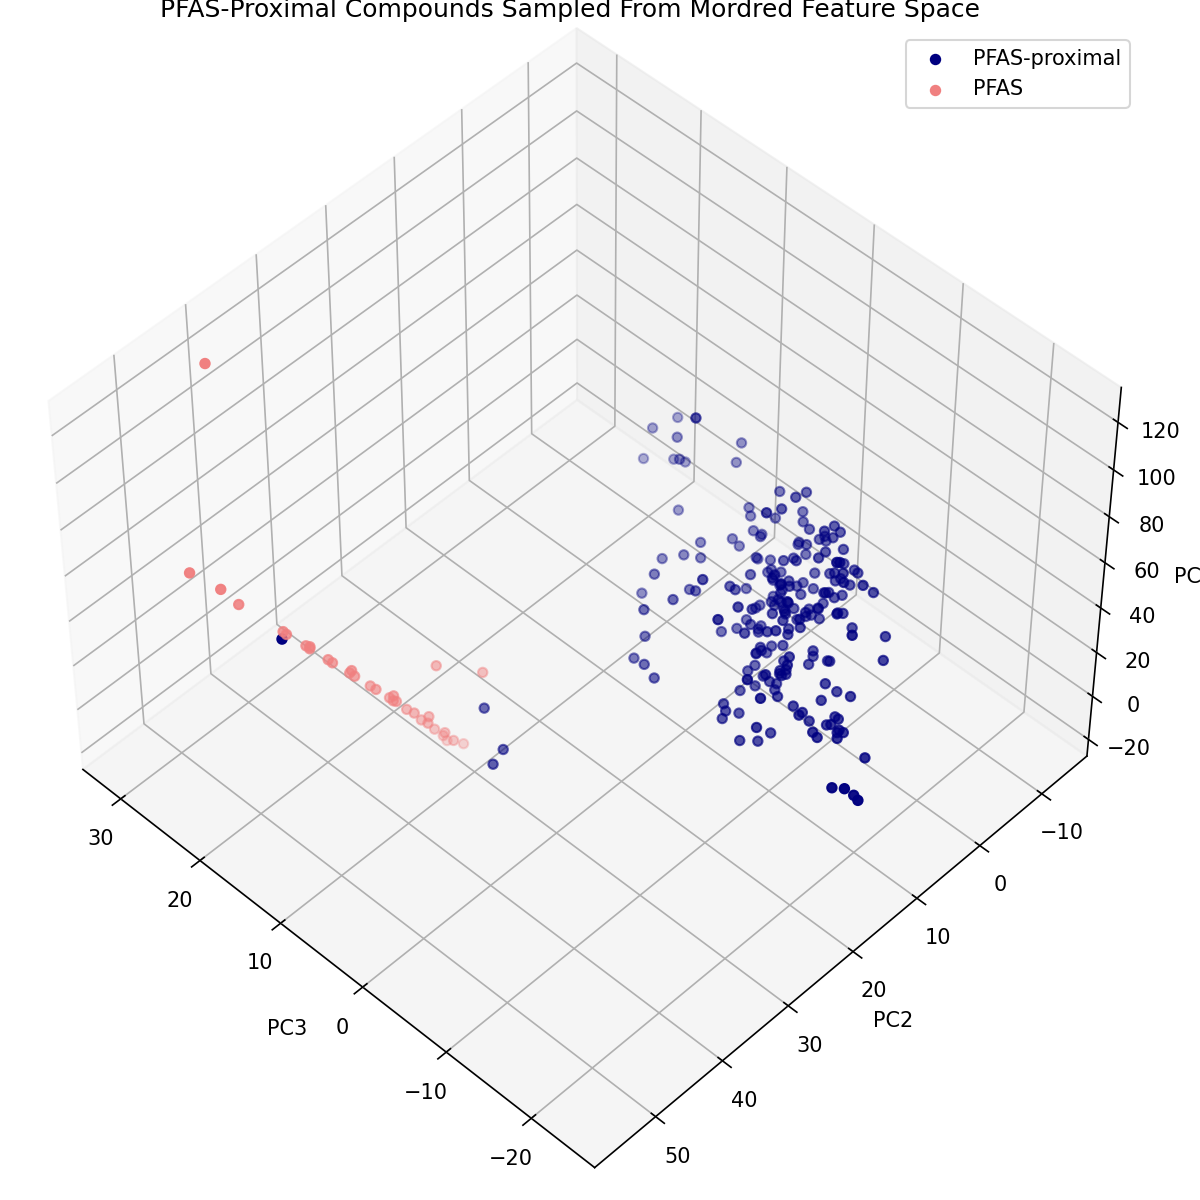

In [15]:
# plot the points that are within distance of centroid for pfas cluster
# PCA 3D for all features
# switch to interactive mode
%matplotlib notebook
# plt.rcParams['figure.figsize'] = [1, 1]
# plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

fig = plt.figure(1, figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])

# going to need same datapoints with some filtered out based on distance
# place label for PFAS and PFAS proximal by new euclidean distance criterion

ax.scatter(X_pca3d_like[:, 2], X_pca3d_like[:, 1], 
           X_pca3d_like[:, 0], c="navy", label = "PFAS-proximal")
ax.scatter(X_pca3d[y_pca == 2, 2], X_pca3d[y_pca == 2, 1], 
           X_pca3d[y_pca == 2, 0], c="lightcoral", label = "PFAS")

ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1')
ax.set_title('PFAS-Proximal Compounds Sampled From Mordred Feature Space')
ax.legend()

<IPython.core.display.Javascript object>


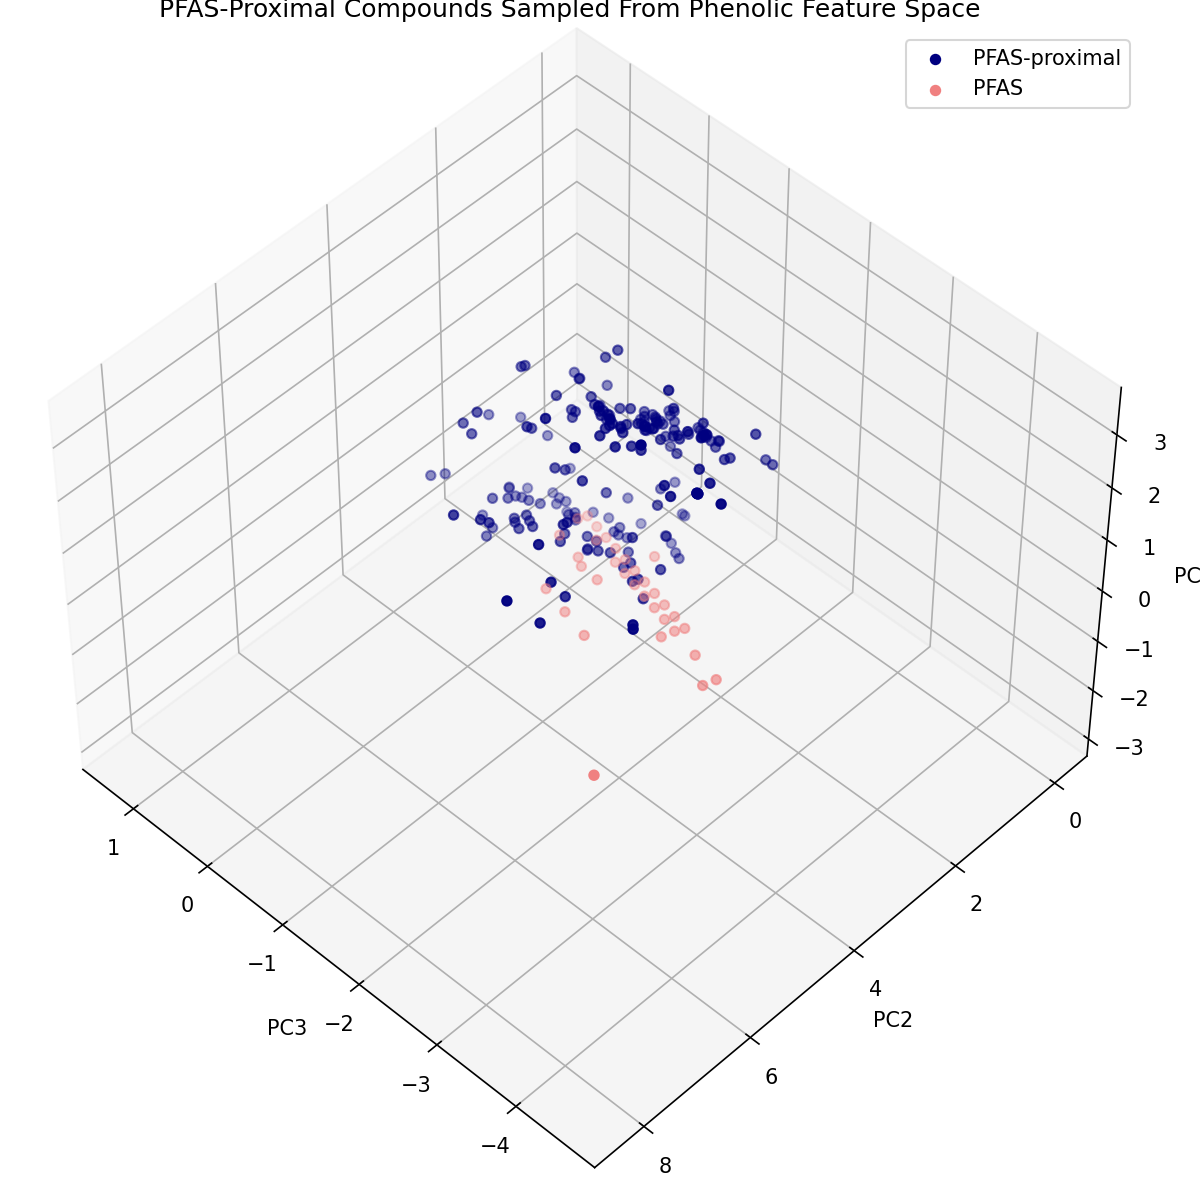

In [16]:
# plot the points that are within distance of centroid for pfas cluster
# PCA 3D for all features
# switch to interactive mode
%matplotlib notebook
# plt.rcParams['figure.figsize'] = [1, 1]
# plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

fig = plt.figure(1, figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])

# going to need same datapoints with some filtered out based on distance
# place label for PFAS and PFAS proximal by new euclidean distance criterion

ax.scatter(X_pca3d_phenol_like[:, 2], X_pca3d_phenol_like[:, 1], 
           X_pca3d_phenol_like[:, 0], c="navy", label = "PFAS-proximal")
ax.scatter(X_pca3d_phenol[y_pca_phenol == 2, 2], X_pca3d_phenol[y_pca_phenol == 2, 1], 
           X_pca3d_phenol[y_pca_phenol == 2, 0], c="lightcoral", label = "PFAS")

ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1')
ax.set_title('PFAS-Proximal Compounds Sampled From Phenolic Feature Space')
ax.legend()

In [17]:
# Export points near centroid for phenolic and mordred feature space for transfer learning
bcf_prox = bcf_mordred.reset_index(drop=True)

# get indices from pca for points that are relevant
# then use indices to index into original dataset row wise --> use to make new columns pfas-proximal
ind = np.arange(len(y_pca))
m_prox_indices = ind[y_pca != 2][mdistance < 55]
p_prox_indices = ind[y_pca_phenol != 2][pdistance < 3]

# output dataframe containing new column: pfas-proximal - mordred, pfas-proximal - phenolic
# make new column label - if index in p_prox_indices, then set pfas-prox phenolic to true
bcf_prox["is_pfas_prox_m"] = False
bcf_prox.loc[m_prox_indices, 'is_pfas_prox_m'] = True
bcf_prox["is_pfas_prox_p"] = False
bcf_prox.loc[p_prox_indices, 'is_pfas_prox_p'] = True

# Some cleanup
bcf_prox.drop("Category", axis=1, inplace=True)
bcf_prox.to_csv('data/bcf_mordred_prox.csv')
# bcf_prox.loc[bcf_prox["is_pfas_prox_p"] == True]